In [ ]:
##!/usr/bin/env python
"""plot_East_West_comparison.py

Script plots the point time series against AWS data to evaluate model data at different lat/lon locations
to understand the contrast across the city

Author: Annette L Hirsch @ CLEX, UNSW. Sydney (Australia)
email: a.hirsch@unsw.edu.au
Created: Thu Jul 30 14:26:12 AEST 2020

"""

In [1]:
import warnings
warnings.filterwarnings("ignore")

Load Packages

In [2]:
#from __future__ import division
import numpy as np
import pandas as pd
import math
import netCDF4 as nc
import sys
import os
import glob as glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
from matplotlib.collections import LineCollection
import common_functions as cf
import datetime as dt
import wrf
from scipy import stats


## Model Data

In [3]:
# Simulation Period
syear = 2017
smon = 1
sday = 2 
eyear = 2017
emon = 2
eday = 28  # Add an extra day so that the 27th Feb data is included
simlen = dt.datetime(eyear,emon,eday) - dt.datetime(syear,smon,sday)
nst = (simlen.days * 24 * 6) # No. simulations days x 24 hours in a day x 6 history intervals per hour

# Dates - Used for subsetting the AWS data so you pick the day before the start date and the day after the end date
sdate = "2017-01-01"
edate = "2017-02-28"

# Data directory 
datadir='/g/data/w97/azh561/WRF/'
ensmem = ['sydney800m','sydney800m_06H','sydney800m_12H','sydney800m_18H','sydney800m_00H']
rlabels = ['U1','U2','U3','U4','U5']
domain = ["d02","d02","d02","d02","d02"]
nmem = len(ensmem)

# Landsea mask
mask_file='/g/data/w97/azh561/WRF/sydney800m_06H/geo_em.%s.nc' %(domain[0])
f = nc.Dataset(mask_file)
topo = f.variables['HGT_M'][0,:,:]
lu = f.variables['LU_INDEX'][0,:,:]
lat2d = f.variables['XLAT_M'][0,:,:]
lontmp = f.variables['XLONG_M'][0,:,:]
lon2d = np.where(lontmp<0.0,lontmp+360,lontmp)
clon = f.getncattr('CEN_LON')
nlu = f.getncattr('NUM_LAND_CAT')
iswater = f.getncattr('ISWATER')
f.close()

print("Domain %s Lat: %s to %s Lon: %s to %s" %(domain[0],np.nanmin(lat2d),np.nanmax(lat2d),np.nanmin(lon2d),np.nanmax(lon2d)))

# Figure Details
fig_dir='%s/figures/' %(os.getcwd())
fig_name_prefix='AWS_comparison_'
if not os.path.exists(fig_dir):
  os.makedirs(fig_dir)


Domain d02 Lat: -35.119434 to -32.14975 Lon: 148.70343 to 152.65186


In [4]:
start = dt.datetime(syear,smon,sday,0,0,0)
end = dt.datetime(eyear,emon,eday,0,0,0)
days = (end - start).days
ntim = days * 24 * 60
datelist = [start + dt.timedelta(minutes=x) for x in range(ntim+1)]
# Get the day-month hour-minutes on 10 minute interval
ftimes = np.asarray([datelist[x].strftime("%m-%d %H-%M") for x in range(ntim+1)])[::10]
fhours = np.asarray([datelist[x].strftime("%H") for x in range(ntim+1)])[::10]
hhmm = np.asarray([datelist[x].strftime("%H-%M") for x in range(ntim+1)])[::10]

In [5]:
midind = [i for i in range(len(hhmm)) if hhmm[i] in ['00-20']] # Get the midday indices in local time +10 hours

In [6]:
HW1S = [i for i in range(len(ftimes)) if ftimes[i] in ['01-11 00-00']][0]
HW1F = [i for i in range(len(ftimes)) if ftimes[i] in ['01-14 12-00']][0]

HW2S = [i for i in range(len(ftimes)) if ftimes[i] in ['01-16 00-00']][0]
HW2F = [i for i in range(len(ftimes)) if ftimes[i] in ['01-18 12-00']][0]

HW3S = [i for i in range(len(ftimes)) if ftimes[i] in ['01-30 00-00']][0]
HW3F = [i for i in range(len(ftimes)) if ftimes[i] in ['02-01 12-00']][0]

HW4S = [i for i in range(len(ftimes)) if ftimes[i] in ['02-05 00-00']][0]
HW4F = [i for i in range(len(ftimes)) if ftimes[i] in ['02-07 12-00']][0]

HW5S = [i for i in range(len(ftimes)) if ftimes[i] in ['02-10 00-00']][0]
HW5F = [i for i in range(len(ftimes)) if ftimes[i] in ['02-12 12-00']][0]

In [7]:
# Function to plot data
def plot_ts(time,tsdata,uwind,foehnflag,tind,vlabels,figurename,lspace):

    """This function plots time series for observations and models"""

    from matplotlib.colors import BoundaryNorm
    from matplotlib.ticker import MaxNLocator
    import string
    import scipy
    
    # Figure formatting
    plt.rcParams['savefig.dpi']=500
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"

    # Define dimensions
    nt = tsdata.shape[0]
      
    # Create figure object and subplots
    fig, ax = plt.subplots(2, 1, figsize=(30.0,14.0), squeeze=False)
    tarr = np.arange(0,nt)
    vind = 0
    ax[0,0].plot(tarr,tsdata, linewidth=2,color='black', linestyle='-')
    ax[1,0].plot(tarr,uwind[0,:], linewidth=2,color='grey', linestyle='-')
    ax[1,0].plot(tarr,uwind[1,:], linewidth=2,color='green', linestyle='-')
       
    # Fix Labelling
    ax[0,0].set_ylabel('%s' %(vlabels[0]), fontweight = 'bold',fontsize=18)
    ax[1,0].set_ylabel('%s' %(vlabels[1]), fontweight = 'bold',fontsize=18)
    ax[0,0].set_title('(%s)' %(string.ascii_lowercase[0]), fontweight='bold', fontsize=18, y = 0.9, x = 0.015)
    ax[1,0].set_title('(%s)' %(string.ascii_lowercase[1]), fontweight='bold', fontsize=18, y = 0.9, x = 0.015)
    

    # Amend axis limits
    ax[0,0].set_xticks([],[])
    ax[0,0].set_xlim(tarr[0],tarr[-1])
    ax[1,0].set_xlim(tarr[0],tarr[-1])
    ax[1,0].set_xticks(tarr[::lspace])
    ax[1,0].set_xticklabels(time[::lspace],rotation=90,fontsize=18)

    # Add vertical line at dates of interest
    #for ll in range(len(tind)): 
    #    ax[vind,0].axvline(tind[ll], color='grey', linestyle='--',linewidth=3.0)
    for vv in range(2):
        ax[vv,0].axvspan(tind[0], tind[1], alpha=0.25, color='red')
        ax[vv,0].axvspan(tind[2], tind[3], alpha=0.25, color='red')
        ax[vv,0].axvspan(tind[4], tind[5], alpha=0.25, color='red')
        ax[vv,0].axvspan(tind[6], tind[7], alpha=0.25, color='red')
        ax[vv,0].axvspan(tind[8], tind[9], alpha=0.25, color='red')

    # Add text to label the heatwaves above the first plot
    ax[0,0].text(0.1875,1.05,'%s HW' %('$1^{st}$'), 
                            horizontalalignment='center',verticalalignment='center',transform = ax[0,0].transAxes,
                            color='black', fontweight='bold', fontsize=18)
    ax[0,0].text(0.265,1.05,'%s HW' %('$2^{nd}$'), 
                            horizontalalignment='center',verticalalignment='center',transform = ax[0,0].transAxes,
                            color='black', fontweight='bold', fontsize=18)
    ax[0,0].text(0.515,1.05,'%s HW' %('$3^{rd}$'), 
                            horizontalalignment='center',verticalalignment='center',transform = ax[0,0].transAxes,
                            color='black', fontweight='bold', fontsize=18)
    ax[0,0].text(0.62,1.05,'%s HW' %('$4^{th}$'), 
                            horizontalalignment='center',verticalalignment='center',transform = ax[0,0].transAxes,
                            color='black', fontweight='bold', fontsize=18)
    ax[0,0].text(0.705,1.05,'%s HW' %('$5^{th}$'), 
                            horizontalalignment='center',verticalalignment='center',transform = ax[0,0].transAxes,
                            color='black', fontweight='bold', fontsize=18)

    ax[0,0].axhline(0., color='grey', linestyle='--',linewidth=3.0)
 #   ax[0,0].axhline(-2.5, color='grey', linestyle='--',linewidth=3.0)
 #   ax[0,0].axhline(-5., color='grey', linestyle='--',linewidth=3.0)
 #   ax[0,0].axhline(-10., color='grey', linestyle='--',linewidth=3.0)
    ax[1,0].axhline(0., color='grey', linestyle='--',linewidth=3.0)

    # Add vertical lines for the Foehn events
    for ll in range(len(foehnflag)):
        ax[0,0].axvline(foehnflag[ll], color='red', linestyle=':',linewidth=5.0)
        ax[1,0].axvline(foehnflag[ll], color='red', linestyle=':',linewidth=5.0)
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
#    fig.savefig(figurename,bbox_inches='tight')
#    plt.close(fig)


In [8]:
# Define function to smooth the timeseries
# Taken from http://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """
    
    if x.ndim != 1:
        sys.exit("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        sys.ext("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        sys.exit("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


## AWS Data

Data Attributes

In [9]:
awsdir = '/g/data/w97/azh561/WRF/obs/AWS_1mindata_20stations'
awsnum = ['067113','WestofPenrith']
awsnm = ['Penrith Lakes','WestofPenrith']
awslat = [-33.7195,-33.7195]
awslon = [150.6783,150.09515]
naws = len(awsnum)

In [16]:
slat = np.empty(naws,dtype=np.int)
slon = np.empty(naws,dtype=np.int)
for ss in range(naws):
    
    # Get lat/lon corresponding to the AWS site
    # https://stackoverflow.com/questions/28006077/find-i-j-location-of-closest-long-lat-values-in-a-2d-array
    a = abs(lat2d-awslat[ss])+abs(lon2d-awslon[ss])
    i0,j0 = np.unravel_index(a.argmin(),a.shape)

    slat[ss] = i0
    slon[ss] = j0
    
    del a,i0,j0
    

## Extract WRF data close to point of interest

In [ ]:
for mm in range(nmem):

    # Files list
    filelist = sorted(glob.glob('%s/%s/WRF_output/%s/wrfout_%s_2017-*' %(datadir,ensmem[mm],domain[mm],domain[mm])))
    nfile = len(filelist)

    #for ff in range(simlen.days):
    for ff in range(int(nfile/24)):

        wrffiles = [nc.Dataset(filelist[(ff*24)]),nc.Dataset(filelist[(ff*24)+1]),nc.Dataset(filelist[(ff*24)+2])
        ,nc.Dataset(filelist[(ff*24)+3]),nc.Dataset(filelist[(ff*24)+4]),nc.Dataset(filelist[(ff*24)+5])
        ,nc.Dataset(filelist[(ff*24)+6]),nc.Dataset(filelist[(ff*24)+7]),nc.Dataset(filelist[(ff*24)+8])
        ,nc.Dataset(filelist[(ff*24)+9]),nc.Dataset(filelist[(ff*24)+10]),nc.Dataset(filelist[(ff*24)+11])
        ,nc.Dataset(filelist[(ff*24)+12]),nc.Dataset(filelist[(ff*24)+13]),nc.Dataset(filelist[(ff*24)+14])
        ,nc.Dataset(filelist[(ff*24)+15]),nc.Dataset(filelist[(ff*24)+16]),nc.Dataset(filelist[(ff*24)+17])
        ,nc.Dataset(filelist[(ff*24)+18]),nc.Dataset(filelist[(ff*24)+19]),nc.Dataset(filelist[(ff*24)+20])
        ,nc.Dataset(filelist[(ff*24)+21]),nc.Dataset(filelist[(ff*24)+22]),nc.Dataset(filelist[(ff*24)+23])]

        # Extract the variables of interest
        timetmp  = wrf.getvar(wrffiles,"times",timeidx=None,method='cat')               # Times
        rh2tmp   = wrf.getvar(wrffiles,"rh2",timeidx=None,method='cat')[:,slat,slon]                         # 2m Relative Humidity
        td2tmp   = wrf.getvar(wrffiles,"td2",units='degC',timeidx=None,method='cat')[:,slat,slon]            # 2m Dew Point Temperature
        t2tmp    = wrf.getvar(wrffiles,'T2',timeidx=None,method='cat')[:,slat,slon] - 273.15                               # 2m temperature
        psfctmp  = wrf.getvar(wrffiles,'PSFC',timeidx=None,method='cat')[:,slat,slon] /100.                                # surface pressure hPa
        prtmp    = wrf.getvar(wrffiles,'RAINC',timeidx=None,method='cat')[:,slat,slon] + wrf.getvar(wrffiles,'RAINNC',timeidx=None,method='cat')[:,slat,slon] # total precipitation mm
        windtmp  = wrf.getvar(wrffiles,"wspd_wdir10",units='km h-1',timeidx=None,method='cat')[:,:,slat,slon] # 10m wind speed and direction
        windtmp  = wrf.getvar(wrffiles,"wspd_wdir10",units='km h-1',timeidx=None,method='cat')[:,:,slat,slon] # 10m wind speed and direction

        # Append to arrays
        if ff == 0:
            ftimes = timetmp
            rh2 = rh2tmp
            td2 = td2tmp
            t2 = t2tmp
            psfc = psfctmp
            pr = prtmp
            wspd = windtmp[0,:,:,:]
            wdir = windtmp[1,:,:,:]
        else:
            ftimes = np.append(ftimes,timetmp,axis=0)
            rh2 = np.append(rh2,rh2tmp,axis=0)
            td2 = np.append(td2,td2tmp,axis=0)
            t2 = np.append(t2,t2tmp,axis=0)
            psfc = np.append(psfc,psfctmp,axis=0)
            pr = np.append(pr,prtmp,axis=0)
            wspd = np.append(wspd,windtmp[0,:,:,:],axis=0)
            wdir = np.append(wdir,windtmp[1,:,:,:],axis=0)

        # Cleanup
        del timetmp,rh2tmp,td2tmp,t2tmp,psfctmp,prtmp,windtmp

    ftimes = ftimes.astype('datetime64[m]')

    if mm == 0:
        tsdata = np.empty((naws,nmem,7,len(ftimes)),dtype=np.float64) # [nmem+1,nvar,ntime]
        times = ftimes

    for ss in range(naws):
        tsdata[ss,mm,0,:len(ftimes)] = psfc[:len(ftimes),ss,ss]
        tsdata[ss,mm,1,:len(ftimes)] = t2[:len(ftimes),ss,ss]
        tsdata[ss,mm,2,:len(ftimes)] = td2[:len(ftimes),ss,ss]
        tsdata[ss,mm,3,:len(ftimes)] = rh2[:len(ftimes),ss,ss]
        tsdata[ss,mm,4,:len(ftimes)] = 0.0 # First set all pr values to zero
        for tt in range(len(pr)-1):
            tsdata[ss,mm,4,tt] = pr[tt+1,ss,ss] - pr[tt,ss,ss]
        tsdata[ss,mm,5,:len(ftimes)] = wspd[:len(ftimes),ss,ss]
        tsdata[ss,mm,6,:len(ftimes)] = wdir[:len(ftimes),ss,ss]

    # Once data read for an ensemble member - write to file - saves read time later!
    for ss in range(naws):
        datadump = np.vstack([tsdata[ss,mm,0,:len(ftimes)], tsdata[ss,mm,1,:len(ftimes)], tsdata[ss,mm,2,:len(ftimes)],
         tsdata[ss,mm,3,:len(ftimes)], tsdata[ss,mm,4,:len(ftimes)], tsdata[ss,mm,5,:len(ftimes)],
            tsdata[ss,mm,6,:len(ftimes)]])
        np.savetxt('WRF_output_M%s_%s_AWS%s.txt' %(ensmem[mm],domain[mm],awsnum[ss]), (datadump.T), delimiter = ' ',header = "PSFC T2 TD2 RH2 PR WSPD WDIR", fmt = '%0.4f %0.4f %0.4f %0.4f %0.4f %0.4f %0.4f')
        del datadump
        
    del psfc,t2,td2,rh2,pr,wspd,wdir,filelist,nfile


## Read in previously extracted data

In [13]:
start = dt.datetime(syear,smon,sday,0,0,0)
end = dt.datetime(eyear,emon,eday,0,0,0)
days = (end - start).days
ntim = days * 24 * 60
datelist = [start + dt.timedelta(minutes=x) for x in range(ntim+1)]
# Get the day-month hour-minutes on 10 minute interval
ftimes = np.asarray([datelist[x].strftime("%m-%d %H-%M") for x in range(ntim+1)])[::10]

In [14]:
tsdata = np.empty((naws,nmem,7,len(ftimes)),dtype=np.float64)
# Loop through the ensemble members
for mm in range(nmem):

    # Loop through the sites
    for ss in range(naws):
    
        # Read data
        data = pd.read_csv('WRF_output_M%s_%s_AWS%s.txt' %(ensmem[mm],domain[mm],awsnum[ss]),delimiter = ' ')
        data.columns = ["PSFC", "T2", "TD2", "RH2", "PR", "WSPD", "WDIR","#"]
    
        tsdata[ss,mm,0,:] = data['PSFC'].iloc[0:len(ftimes)]
        tsdata[ss,mm,1,:] = data['T2'].iloc[0:len(ftimes)]
        tsdata[ss,mm,2,:] = data['TD2'].iloc[0:len(ftimes)]
        tsdata[ss,mm,3,:] = data['RH2'].iloc[0:len(ftimes)]
        tsdata[ss,mm,4,:] = data['PR'].iloc[0:len(ftimes)]
        tsdata[ss,mm,5,:] = data['WSPD'].iloc[0:len(ftimes)]
        tsdata[ss,mm,6,:] = data['WDIR'].iloc[0:len(ftimes)]
    
        del data

In [17]:
# Calculate the ensemble mean
ensmean = np.nanmean(tsdata,axis=1)

# Estimate the temperature change dT/dz in units of degC/km   
lapserate = ((ensmean[1,1,:] - ensmean[0,1,:]) / (topo[slat,slon][-1] - topo[slat,slon][0]))*1000

# Calculate the u-wind component
uwind = tsdata[:,:,5,:] * np.cos(np.deg2rad(tsdata[:,:,6,:]))
umean = np.nanmean(uwind, axis=1)


### Read in the data from: 

Abatzoglou, J. T., Hatchett, B. J., Fox-Hughes, P., Gershunov, A., and Nauslar, N. J. (2020). Global climatology of synoptically-forced downslope winds. International Journal of Climatology, doi:10.1002/joc.6607.

In [50]:
foehnfn = '/g/data/w97/azh561/WRF/abatzoglou_foehn/downslopeday_2017.nc'
foehnfile = nc.Dataset(foehnfn)
foehndata = foehnfile.variables['downslope'][:,:,:]
foehnlat = foehnfile.variables['lat'][:]
foehnlon = foehnfile.variables['lon'][:]
foehntime = foehnfile.variables['time'][:]
foehnfile.close()

flon2d, flat2d = np.meshgrid(foehnlon, foehnlat)

# Define Location to Zoom in on – here using the extent of the latitude and longitude of the inner domain d02
coordslat = [np.nanmin(lat2d),np.nanmax(lat2d)]
coordslon = [np.nanmin(lon2d),np.nanmax(lon2d)]
ncoords = 2

flat = np.empty(ncoords,dtype=np.int)
flon = np.empty(ncoords,dtype=np.int)
for ss in range(ncoords):
    
    # Get lat/lon corresponding to the AWS site
    # https://stackoverflow.com/questions/28006077/find-i-j-location-of-closest-long-lat-values-in-a-2d-array
    a = abs(flat2d-coordslat[ss])+abs(flon2d-coordslon[ss])
    i0,j0 = np.unravel_index(a.argmin(),a.shape)

    flat[ss] = i0
    flon[ss] = j0
    
    del a,i0,j0

# Retrieve the downslope foehndata for the inner domain and simulation dates (here 2.01.2017 to 27.02.2017)
foehnsubset = foehndata[1:(31+27),flat[-1]:flat[0],flon[0]:flon[1]]

# Calculate the sum along the longitudes to ensure the escarpment is captured and then convert values great than 1 to 1
foehntimelat = np.where(np.nansum(foehnsubset,axis=2)>=1.0,1.0,0.0)

# Loop through each day and when 50% of the latitudes have a downslope wind, this is flagged as a Foehnday
foehnthres = np.floor(foehnsubset.shape[1] * 0.5)
foehnday = []
for tt in range(len(foehnflag)):
    foehnlatsum = np.nansum(foehntimelat[tt,:])
    if foehnlatsum > foehnthres:
        foehnday = np.append(foehnday,midind[tt])
        print(ftimes[midind[tt]])
    del foehnlatsum
    

01-03 00-20
01-13 00-20
01-14 00-20
01-20 00-20
02-04 00-20
02-07 00-20
02-08 00-20
02-12 00-20
02-14 00-20
02-17 00-20
02-19 00-20
02-25 00-20
02-26 00-20
02-27 00-20


In [46]:
foehnsubset.shape[0]

57

In [47]:
ftimes

array(['01-02 00-00', '01-02 00-10', '01-02 00-20', ..., '02-27 23-40',
       '02-27 23-50', '02-28 00-00'], dtype='<U11')

In [39]:
foehnday

array([ 146., 1586., 1730., 2594., 4754., 5186., 5330., 5906., 6194.,
       6626., 6914., 7778., 7922., 8066.])

### Plot time series

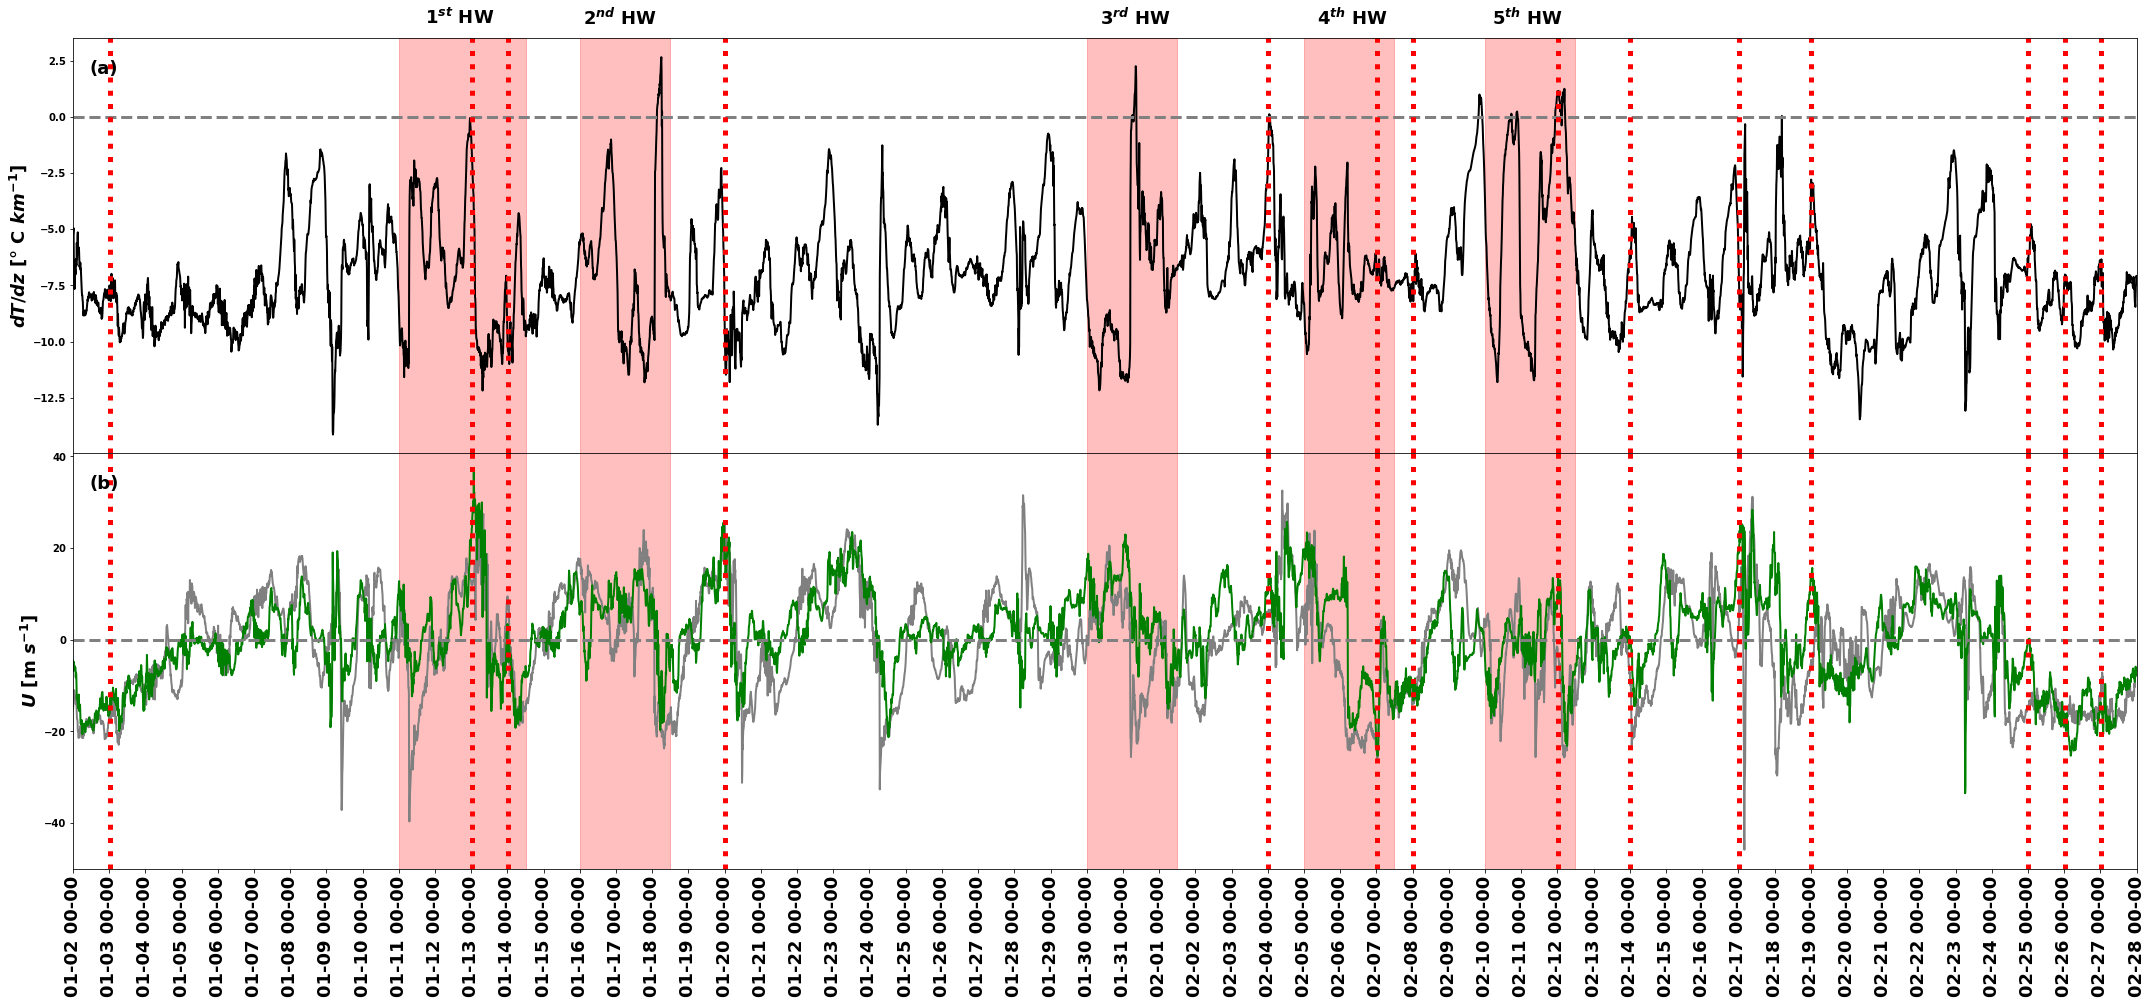

In [40]:
tind = [HW1S,HW1F,HW2S,HW2F,HW3S,HW3F,HW4S,HW4F,HW5S,HW5F]
vlabels = ['$dT/dz$ [\xb0 C $km^{-1}$]','$U$ [m $s^{-1}$]']
figurename='lapserate_time_series.png'
plot_ts(ftimes,lapserate,umean,foehnday,tind,vlabels,figurename,144)

In [49]:
ftimes[ind]

array(['01-18 03-10', '01-18 03-20', '01-18 03-30', '01-18 03-40',
       '01-18 03-50', '01-18 04-00', '01-18 04-10', '01-18 04-20',
       '01-18 04-30', '01-18 04-40', '01-18 04-50', '01-18 05-00',
       '01-18 05-10', '01-18 05-20', '01-18 05-30', '01-18 05-40',
       '01-18 05-50', '01-18 06-00', '01-18 06-10', '01-18 06-30',
       '01-31 07-20', '01-31 07-30', '01-31 07-40', '01-31 07-50',
       '01-31 08-00', '01-31 08-10', '01-31 08-20', '01-31 08-30',
       '01-31 08-40', '01-31 08-50', '02-04 01-00', '02-09 19-50',
       '02-09 20-00', '02-09 20-10', '02-09 20-20', '02-09 20-30',
       '02-09 20-40', '02-09 20-50', '02-09 21-00', '02-09 21-10',
       '02-09 21-20', '02-09 21-30', '02-09 21-40', '02-09 21-50',
       '02-09 22-00', '02-10 17-30', '02-10 21-00', '02-10 21-10',
       '02-10 21-20', '02-10 21-30', '02-11 22-40', '02-11 22-50',
       '02-11 23-00', '02-11 23-10', '02-11 23-20', '02-11 23-30',
       '02-11 23-40', '02-11 23-50', '02-12 00-00', '02-12 00-

### Days where dT/dz has positive instances

    18th Jan
    31st Jan
    4th Feb
    9-12th Feb

In [53]:
[topo[slat,slon][-1],topo[slat,slon][0]] # [1066.7351, 16.937439]

[1066.7351, 16.937439]